# 三维重建之神经辐射场 (NeRF)

在这个例子中，我们展示了研究论文 [NeRF](https://arxiv.org/abs/2003.08934) 的最小实现：将场景表示为 Ben Mildenhall 等人的视图合成的神经辐射场。作者提出了一种巧妙的方法，通过神经网络对体积场景函数进行建模，从而合成场景的新视图。

为了帮助您直观地理解这一点，让我们从以下问题开始：是否可以将图像中像素的位置提供给神经网络，并要求网络预测该位置的颜色？

<figure>
<img src="images/nerf_pipeline_1.png" width="500" alt="nerf_pipeline_1">
<figcaption>图 1：给定图像坐标的神经网络作为输入并要求预测坐标处的颜色。</figcaption>
</figure>

神经网络会假设记忆（过拟合）图像。这意味着我们的神经网络会将整个图像编码为其权重。我们可以用每个位置查询神经网络，它最终会重建整个图像。

<figure>
<img src="images/nerf_pipeline_2.png" width="500" alt="nerf_pipeline_1">
<figcaption>图 2：经过训练的神经网络从头开始重新创建图像。</figcaption>
</figure>

现在出现了一个问题，我们如何扩展这个想法来学习 3D 体积场景？实现与上述类似的过程需要了解每个体素（体积像素）。事实证明，这是一项非常具有挑战性的任务。

该论文的作者提出了一种使用场景的一些图像来学习 3D 场景的最小而优雅的方法。他们放弃使用体素进行训练。网络学习对体积场景进行建模，从而生成模型在训练时未显示的 3D 场景的新视图（图像）。

需要了解一些先决条件才能充分理解这一过程。我们以这样一种方式构建示例，以便您在开始实施之前拥有所有必需的知识。

## 设置

In [1]:
import os

os.environ["GLOG_v"] = "3"

import cv2
import json
import time
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

import mindspore
import mindspore as md
import mindspore.ops.operations as P
from mindspore import nn
import mindspore as md


# environment config
mode = "PYNATIVE_MODE"
seed = 1
gpu = 0
device = "GPU"
init = False

# data config
half_res = True
testskip = 8
white_bkgd = True
render_test = True

# network config
chunk = 32768
cap_n_samples = 64
cap_n_importance = 0
netchunk = 65536
lrate = 0.0005

# runner config
cap_n_iters = 3000
cap_n_rand = 1024
i_testset = 100
lrate_decay = 250


def context_setup(idx, device='GPU', mode=md.context.PYNATIVE_MODE):
    if init:
        return
    if device == "CPU":
        raise NotImplementedError("`cumprod` ops does not support CPU")
    md.context.set_context(mode=mode, device_target=device, device_id=idx)

md.set_seed(seed)
context_setup(gpu, device, getattr(md.context, mode))

## 下载并加载数据

### 预备知识

数据文件包含图像、相机姿势和焦距。这些图像是从多个摄像机角度拍摄的，如图 3 所示。

<figure>
<img src="images/nerf_data_1.png" width="500" alt="nerf_pipeline_1">
<figcaption>图 3：多个摄像机角度。</figcaption>
</figure>

要在这种情况下理解相机姿势，我们必须首先让自己认为相机是现实世界和二维图像之间的映射。

<figure>
<img src="images/nerf_data_2.png" width="500" alt="nerf_pipeline_1">
<figcaption>图 4：通过相机将 3-D 世界映射到 2-D 图像。</figcaption>
</figure>

考虑以下等式：

$$
x = PX
$$

其中 x 是 2-D 图像点，X 是 3-D 世界点，P 是相机矩阵。P是 一个 3 x 4 矩阵，在将现实世界对象映射到图像平面上起着至关重要的作用。

$$
\begin{bmatrix}
X \\
Y \\
Z
\end{bmatrix}

=

\begin{bmatrix}
p_1 & p_2 & p_3 & p_4 \\
p_5 & p_6 & p_7 & p_8 \\
p_9 & p_{10} & p_{11} & p_{12} \\
\end{bmatrix}

\begin{bmatrix}
X \\
Y \\
Z \\
1
\end{bmatrix}
$$

相机矩阵是一个仿射变换矩阵，它与一个 3 x 1 列连接 `[image height, image width, focal length]`以产生姿势矩阵。该矩阵的尺寸为 3 x 5，其中第一个 3 x 3 块位于相机的视点中。轴是 `[down, right, backwards]` 或 `[-y, x, z]` 相机面向前方的位置-z。

<figure>
<img src="images/nerf_data_3.png" width="500" alt="nerf_pipeline_1">
<figcaption>图 5：仿射变换。</figcaption>
</figure>

COLMAP 帧是 `[right, down, forwards]` 或 `[x, -y, -z]`。[在此处](https://colmap.github.io/)阅读有关 COLMAP 的更多信息。

### 下载数据

首先自行下载数据: [NeRF Synthetics](https://drive.google.com/file/d/18JxhpWD-4ZmuFKLzKlAw-w5PpzZxXOcG/view?usp=sharing).

下载数据后, 按照以下结构安排数据:

```text
.datasets/
└── nerf_synthetics
    └── lego
        ├── test [600 entries exceeds filelimit, not opening dir]
        ├── train [100 entries exceeds filelimit, not opening dir]
        ├── transforms_test.json
        ├── transforms_train.json
        ├── transforms_val.json
        └── val [100 entries exceeds filelimit, not opening dir]
```

### 加载数据

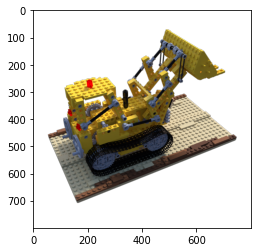

In [2]:
datadir = Path("datasets/nerf_synthetics/lego")
train_imgs = list((datadir / "train").glob("*.png"))
num_images = len(train_imgs)

temp_fname = str(train_imgs[np.random.randint(low=0, high=num_images)])
tmp_img = cv2.imread(temp_fname, cv2.IMREAD_UNCHANGED)
tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGRA2RGBA)

plt.imshow(tmp_img)
plt.show()

## 数据管线

现在您已经了解了相机矩阵的概念以及从 3D 场景到 2D 图像的映射，让我们来谈谈逆映射，即从 2D 图像到 3D 场景。

我们需要讨论使用光线投射和追踪的体积渲染，这是常见的计算机图形技术。本节将帮助您快速掌握这些技术。

考虑一个带有 `N` 像素的图像。我们通过每个像素射出一条射线，并在射线上采样一些点。射线通常由方程参数化，`r(t) = o + td` 其中 `t` 是参数，`o` 是原点并且 `d` 是单位方向矢量。

我们考虑一条射线，并在射线上采样一些随机点。这些采样点每个都有一个独特的位置`(x, y, z)`，并且光​​线有一个视角`(theta, phi)`。视角特别有趣，因为我们可以通过许多不同的方式通过单个像素拍摄光线，每种方式都有独特的视角。这里要注意的另一件有趣的事情是添加到采样过程中的噪声。我们为每个样本添加均匀的噪声，使样本对应于连续分布。这些采样点作为 NeRF 模型的输入。然后要求模型预测该点的 RGB 颜色和体积密度。

<figure>
<img src="images/nerf_data_pipeline.png" width="500" alt="nerf_pipeline_1">
<figcaption>图 6：数据管线</figcaption>
</figure>

In [3]:
def trans_t(t):
    return md.Tensor([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, t], [0, 0, 0, 1]],
                     dtype=md.float32)


def rot_phi(phi):
    return md.Tensor([[1, 0, 0, 0], [0, np.cos(phi), -np.sin(phi), 0],
                      [0, np.sin(phi), np.cos(phi), 0], [0, 0, 0, 1]],
                     dtype=md.float32)


def rot_theta(th):
    return md.Tensor([[np.cos(th), 0, -np.sin(th), 0], [0, 1, 0, 0],
                      [np.sin(th), 0, np.cos(th), 0], [0, 0, 0, 1]],
                     dtype=md.float32)


def pose_spherical(theta, phi, radius):
    """pose_spherical"""
    c2w = trans_t(radius)
    c2w = md.ops.matmul(rot_phi(phi / 180. * np.pi), c2w)
    c2w = md.ops.matmul(rot_theta(theta / 180. * np.pi), c2w)
    c2w = md.ops.matmul(
        md.Tensor(
            np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0,
                                                                  1]])), c2w)
    return c2w


def load_blender_data(basedir, half_res=False, testskip=1):
    """load_blender_data"""
    splits = ['train', 'val', 'test']
    metas = {}
    for s in splits:
        with open(os.path.join(basedir, f'transforms_{s}.json'),
                  'r',
                  encoding='utf-8') as fp:
            metas[s] = json.load(fp)

    all_imgs = []
    all_poses = []
    counts = [0]
    for s in splits:
        meta = metas[s]
        imgs = []
        poses = []
        if s == 'train' or testskip == 0:
            skip = 1
        else:
            skip = testskip

        for frame in meta['frames'][::skip]:
            fname = os.path.join(basedir, frame['file_path'] + '.png')
            tmp_img = cv2.imread(fname, cv2.IMREAD_UNCHANGED)
            tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGRA2RGBA)
            imgs.append(tmp_img)
            poses.append(np.array(frame['transform_matrix']))
        imgs = (np.array(imgs) / 255.).astype(
            np.float32)  # keep all 4 channels (RGBA)
        poses = np.array(poses).astype(np.float32)
        counts.append(counts[-1] + imgs.shape[0])
        all_imgs.append(imgs)
        all_poses.append(poses)

    i_split = [np.arange(counts[i], counts[i + 1]) for i in range(3)]

    imgs = np.concatenate(all_imgs, 0)
    poses = np.concatenate(all_poses, 0)

    cap_h, cap_w = imgs[0].shape[:2]
    camera_angle_x = float(meta['camera_angle_x'])
    focal = .5 * cap_w / np.tan(.5 * camera_angle_x)

    stack_op = md.ops.Stack(axis=0)
    render_poses = stack_op([
        pose_spherical(angle, -30.0, 4.0)
        for angle in np.linspace(-180, 180, 40 + 1)[:-1]
    ])

    if half_res:
        cap_h = cap_h // 8
        cap_w = cap_w // 8
        focal = focal / 8.

        imgs_half_res = np.zeros((imgs.shape[0], cap_h, cap_w, 4))
        for i, img in enumerate(imgs):
            imgs_half_res[i] = cv2.resize(img, (cap_h, cap_w),
                                          interpolation=cv2.INTER_AREA)
        imgs = imgs_half_res

    return md.Tensor(imgs).astype("float32"), md.Tensor(poses).astype(
        "float32"), md.Tensor(render_poses).astype("float32"), [
            cap_h, cap_w, focal
        ], i_split


images, poses, render_poses, hwf, i_split = load_blender_data(datadir, half_res, testskip)
print('Loaded blender', images.shape, render_poses.shape, hwf, datadir)
i_train, i_val, i_test = i_split

near = 2.
far = 6.

if white_bkgd:
    images = images[..., :3] * images[..., -1:] + (1. - images[..., -1:])
else:
    images = images[..., :3]

if render_test:
    render_poses = poses[i_test.tolist()]

# Cast intrinsics to right types
cap_h, cap_w, focal = hwf
cap_h, cap_w = int(cap_h), int(cap_w)

hwf = [cap_h, cap_w, focal]

Loaded blender (138, 100, 100, 4) (40, 4, 4) [100, 100, 138.88887889922103] datasets/nerf_synthetics/lego


## NeRF 模型

该模型是一个多层感知器 (MLP)，以 ReLU 作为其非线性。

论文摘录：

“我们通过限制网络将体积密度 sigma 预测为仅位置的函数来鼓励表示是多视图一致的 x，同时允许将 RGB 颜色c预测为位置和查看方向的函数。为此， MLP 首先使用 8 个全连接层（使用 ReLU 激活和每层 256 个通道）处理输入 3D 坐标，并输出 sigma 和 256 维特征向量。然后将该特征向量与相机光线的观察方向连接并传递到一个额外的全连接层（使用 ReLU 激活和 128 个通道），输出与视图相关的 RGB 颜色。”

<figure>
<img src="images/nerf_model.png" width="500" alt="nerf_pipeline_1">
<figcaption>图 7：NeRF 模型</figcaption>
</figure>



In [4]:
class NeRFMLP(nn.Cell):
    """NeRF MLP architecture.

    Args:
        cap_d (int, optional): model depth. Defaults to 8.
        cap_w (int, optional): model width. Defaults to 256.
        input_ch (int, optional): input channel. Defaults to 3.
        input_ch_views (int, optional): input view channel. Defaults to 3.
        output_ch (int, optional): output channel. Defaults to 4.
        skips (tuple, optional): skip connection layer index. Defaults to (4).
        use_viewdirs (bool, optional): use view directions or not. Defaults to False.

    Inputs:
        x (Tensor): query tensors: points and view directions (..., 6)

    Outputs:
        (Tensor): query features (..., feature_dims)
    """

    def __init__(self,
                 cap_d=8,
                 cap_w=256,
                 input_ch=3,
                 input_ch_views=3,
                 output_ch=4,
                 skips=(4),
                 use_viewdirs=False):
        """NeRF MLP architecture.

        Args:
            cap_d (int, optional): model depth. Defaults to 8.
            cap_w (int, optional): model width. Defaults to 256.
            input_ch (int, optional): input channel. Defaults to 3.
            input_ch_views (int, optional): input view channel. Defaults to 3.
            output_ch (int, optional): output channel. Defaults to 4.
            skips (tuple, optional): skip connection layer index. Defaults to (4).
            use_viewdirs (bool, optional): use view directions or not. Defaults to False.
        """
        super().__init__()
        self.cap_d = cap_d
        self.cap_w = cap_w
        self.input_ch = input_ch
        self.input_ch_views = input_ch_views
        self.skips = skips
        self.use_viewdirs = use_viewdirs

        self.pts_linears = nn.CellList(
            [nn.Dense(in_channels=input_ch, out_channels=cap_w)] + [
                nn.Dense(in_channels=cap_w, out_channels=cap_w) if i not in
                self.skips else nn.
                Dense(in_channels=cap_w + input_ch, out_channels=cap_w)
                for i in range(cap_d - 1)
            ])

        # Implementation according to the official code release (https://github.com/bmild/nerf/blob/master/run_nerf_helpers.py#L104-L105)
        self.views_linears = nn.CellList([
            nn.Dense(in_channels=input_ch_views + cap_w,
                     out_channels=cap_w // 2)
        ])

        # Implementation according to the paper
        # self.views_linears = nn.CellList(
        #     [nn.Dense(input_ch_views + W, W//2)] + [nn.Dense(W//2, W//2) for i in range(D//2)])

        if use_viewdirs:
            self.feature_linear = nn.Dense(in_channels=cap_w,
                                           out_channels=cap_w)
            self.alpha_linear = nn.Dense(in_channels=cap_w, out_channels=1)
            self.rgb_linear = nn.Dense(in_channels=cap_w // 2, out_channels=3)
        else:
            self.output_linear = nn.Dense(in_channels=cap_w,
                                          out_channels=output_ch)

    def construct(self, x):
        """NeRF MLP construct

        Inputs:
            x (Tensor): query tensors: points and view directions (..., 6)

        Outputs:
            (Tensor): query features (..., feature_dims)
        """
        input_pts, input_views = x[..., :self.input_ch], x[..., self.input_ch:]
        h = input_pts
        for i, _ in enumerate(self.pts_linears):
            h = self.pts_linears[i](h)
            h = P.ReLU()(h)
            if i in self.skips:
                h = P.Concat(-1)([input_pts, h])

        if self.use_viewdirs:
            alpha = self.alpha_linear(h)
            feature = self.feature_linear(h)
            h = P.Concat(-1)([feature, input_views])

            for i, _ in enumerate(self.views_linears):
                h = self.views_linears[i](h)
                h = P.ReLU()(h)

            rgb = self.rgb_linear(h)
            outputs = P.Concat(-1)([rgb, alpha])
        else:
            outputs = self.output_linear(h)

        return outputs

class Embedder(nn.Cell):
    """Embedder for positional embedding

    Args:
        input_dims (int): input_dims
        max_freq_pow (float): max_freq_pow
        num_freqs (int): num_freqs
        periodic_fns (list, optional): periodic_fns. Defaults to [mindspore.ops.Sin(), mindspore.ops.Cos()].
        log_sampling (bool, optional): log_sampling. Defaults to True.
        include_input (bool, optional): include_input. Defaults to True.

    Inputs:
        inputs (Tensor): input tensor

    Output:
        Tensor: input concatenated with positional embeddings
    """

    def __init__(self,
                 input_dims,
                 max_freq_pow,
                 num_freqs,
                 periodic_fns=(mindspore.ops.Sin(), mindspore.ops.Cos()),
                 log_sampling=True,
                 include_input=True):
        """Embedder for positional embedding

        Args:
            input_dims (int): input_dims
            max_freq_pow (float): max_freq_pow
            num_freqs (int): num_freqs
            periodic_fns (list, optional): periodic_fns. Defaults to [mindspore.ops.Sin(), mindspore.ops.Cos()].
            log_sampling (bool, optional): log_sampling. Defaults to True.
            include_input (bool, optional): include_input. Defaults to True.
        """
        super().__init__()

        embed_fns = []
        out_dims = 0
        if include_input:
            embed_fns.append(mindspore.ops.Identity())
            out_dims += input_dims

        if log_sampling:
            freq_bands = mindspore.Tensor(2.0)**mindspore.numpy.linspace(
                0., max_freq_pow, num=num_freqs)
        else:
            freq_bands = mindspore.numpy.linspace(2.0**0.0,
                                                  2.0**max_freq_pow,
                                                  num=num_freqs)

        for _ in freq_bands:
            for p_fn in periodic_fns:
                embed_fns.append(p_fn)
                out_dims += input_dims

        self.embed_fns = embed_fns
        self.out_dims = out_dims

        self.freq_bands = freq_bands

    def construct(self, inputs):
        """construct

        Inputs:
            inputs (Tensor): input tensor

        Output:
            Tensor: input concatenated with positional embeddings
        """
        out = []
        for i, fn in enumerate(self.embed_fns):
            if i == 0:
                out.append(fn(inputs))
            else:
                out.append(fn(inputs * self.freq_bands[(i - 1) // 2]))
        return P.Concat(-1)(out)


def get_embedder(multires, i=0):
    """get embedder

    Args:
        multires (int): log2 of max freq for positional encoding.
        i (int, optional): set 0 for default positional encoding, -1 for none. Defaults to 0.

    Returns:
        (nn.Cell, int): embedder, the output dims.
    """
    if i == -1:
        return md.ops.Identity(), 3

    embed_kwargs = {
        'include_input': True,
        'input_dims': 3,
        'max_freq_pow': multires - 1,
        'num_freqs': multires,
        'log_sampling': True,
        'periodic_fns': [md.ops.Sin(), md.ops.Cos()],
    }

    embedder_obj = Embedder(**embed_kwargs)
    embed = embed_kwargs
    return embed, embedder_obj.out_dims


## 可微分渲染器

In [5]:
class VolumeRenderer(nn.Cell):
    """VolumeRenderer architecture.

    Args:
        chunk (int): number of rays processed in parallel, decrease if running out of memory
        cap_n_samples (int): number of coarse samples per ray for coarse net
        cap_n_importance (int): number of additional fine samples per ray for fine net
        netchunk (int): number of pts sent through network in parallel, decrease if running out of memory
        white_bkgd (bool): set to render synthetic data on a white background (always use for DeepVoxels)
        model_coarse (nn.Cell): coarse net
        model_fine (nn.Cell, optional): fine net, or None
        embedder_p (Dict): config for positional encoding for point
        embedder_d (Dict): config for positional encoding for view direction
        near (float, optional): the near plane. Defaults to 0.0.
        far (float, optional): the far plane. Defaults to 1e6.

    Inputs:
        rays (rays): the ray tensor (..., num_pts_per_ray, ray_batch_dims)

    Outputs:
        ((Tensor, optional), Tensor): the fine net output features or None, and the coarse net output features
    """

    def __init__(self,
                 chunk,
                 cap_n_samples,
                 cap_n_importance,
                 netchunk,
                 white_bkgd,
                 model_coarse,
                 model_fine,
                 embedder_p,
                 embedder_d,
                 near=0.0,
                 far=1e6):
        """VolumeRenderer architecture.

        Args:
            chunk (int): number of rays processed in parallel, decrease if running out of memory
            cap_n_samples (int): number of coarse samples per ray for coarse net
            cap_n_importance (int): number of additional fine samples per ray for fine net
            netchunk (int): number of pts sent through network in parallel, decrease if running out of memory
            white_bkgd (bool): set to render synthetic data on a white background (always use for DeepVoxels)
            model_coarse (nn.Cell): coarse net
            model_fine (nn.Cell, optional): fine net, or None
            embedder_p (Dict): config for positional encoding for point
            embedder_d (Dict): config for positional encoding for view direction
            near (float, optional): the near plane. Defaults to 0.0.
            far (float, optional): the far plane. Defaults to 1e6.
        """
        super().__init__()

        # self.config = config
        self.chunk = chunk
        self.cap_n_samples = cap_n_samples
        self.cap_n_importance = cap_n_importance
        self.netchunk = netchunk
        self.white_bkgd = white_bkgd

        # coarse model
        self.model_coarse = model_coarse
        # fine model
        self.model_fine = model_fine
        # embedder for positions
        self.embedder_p = Embedder(**embedder_p)
        # embedder for view-in directions
        self.embedder_d = Embedder(**embedder_d)

        self.near = near
        self.far = far

    def construct(self, rays):
        """volume renderer construct

        Inputs:
            rays (rays): the ray tensor (..., num_pts_per_ray, ray_batch_dims)

        Outputs:
            ((Tensor, optional), Tensor): the fine net output features or None, and the coarse net output features
        """
        # make the number of rays be multiple of the chunk size
        cap_n_rays = (rays.shape[1] // self.chunk + 1) * self.chunk
        cap_n = self.cap_n_samples

        res_ls = {"rgb_map_coarse": [], "rgb_map_fine": []}

        for i in range(0, cap_n_rays, self.chunk):
            ray_oris, ray_dirs = rays[:, i:i + self.chunk, :]
            reshape_op = mindspore.ops.Reshape()
            view_dirs = reshape_op(
                ray_dirs /
                mindspore.numpy.norm(ray_dirs, axis=-1, keepdims=True),
                (-1, 3))
            cast_op = P.Cast()
            view_dirs = cast_op(view_dirs, mindspore.float32)
            near, far = self.near * mindspore.numpy.ones_like(
                ray_dirs[..., :1]), self.far * mindspore.numpy.ones_like(
                    ray_dirs[..., :1])
            cap_m = ray_oris.shape[0]  # chunk size
            if cap_m == 0:
                continue

            # stratified sampling along rays
            s_samples = sample_along_rays(near, far, cap_n)

            # position samples along rays
            unsqueeze_op = P.ExpandDims()
            pos_samples = unsqueeze_op(ray_oris, 1) + unsqueeze_op(
                ray_dirs, 1) * unsqueeze_op(s_samples, 2)  # (M, N, 3)
            # expand ray directions to the same shape of samples
            expand_op = P.BroadcastTo(pos_samples.shape)
            dir_samples = expand_op(unsqueeze_op(view_dirs, 1))

            reshape_op = P.Reshape()
            pos_samples = reshape_op(pos_samples, (-1, 3))  # (M * N, 3)
            dir_samples = reshape_op(dir_samples, (-1, 3))  # (M * N, 3)

            # retrieve optic data from the network
            optic_d = self._run_network_model_coarse(pos_samples, dir_samples)
            optic_d = mindspore.numpy.reshape(optic_d, [cap_m, cap_n, 4])

            # composite optic data to generate a RGB image
            rgb_map_coarse, weights_coarse = self._composite(
                optic_d, s_samples, ray_dirs)

            if self.cap_n_importance > 0:
                z_vals_mid = 0.5 * (s_samples[..., 1:] + s_samples[..., :-1])
                z_samples = sample_pdf(z_vals_mid, weights_coarse[..., 1:-1],
                                       self.cap_n_importance)
                z_samples = mindspore.ops.stop_gradient(z_samples)

                sort_op = P.Sort(axis=-1)
                z_vals, _ = sort_op(P.Concat(-1)([s_samples, z_samples]))
                pts = (ray_oris[..., None, :] +
                       ray_dirs[..., None, :] * z_vals[..., :, None]
                       )  # [N_rays, N_samples + N_importance, 3]

                expand_op_2 = P.BroadcastTo(pts.shape)
                dir_samples = expand_op_2(unsqueeze_op(view_dirs, 1))

                pts = reshape_op(pts, (-1, 3))
                dir_samples = reshape_op(dir_samples, (-1, 3))

                optic_d = self._run_network_model_fine(pts, dir_samples)
                optic_d = reshape_op(optic_d,
                                     (cap_m, cap_n + self.cap_n_importance, 4))

                rgb_map_fine, _ = self._composite(optic_d, z_vals, ray_dirs)
            else:
                rgb_map_fine = rgb_map_coarse

            res_ls["rgb_map_coarse"].append(rgb_map_coarse)
            res_ls["rgb_map_fine"].append(rgb_map_fine)

        res = {}
        for k, v in res_ls.items():
            res[k] = P.Concat(0)(v)

        return res["rgb_map_fine"], res["rgb_map_coarse"]

    def _run_network_model_fine(self, pts, view_dirs):
        """run_network_model_fine"""
        inputs_flat = pts
        embedded = self.embedder_p(inputs_flat)

        if view_dirs is not None:
            input_dirs_flat = view_dirs
            embedded_dirs = self.embedder_d(input_dirs_flat)
            embedded = P.Concat(-1)([embedded, embedded_dirs])

        chunk = self.netchunk
        outputs_flat_ls = []
        for i in range(0, embedded.shape[0], chunk):
            outputs_flat_ls.append(self.model_fine(embedded[i:i + chunk]))
        outputs_flat = P.Concat(0)(outputs_flat_ls)
        return outputs_flat

    def _run_network_model_coarse(self, pts, view_dirs):
        """run_network_model_coarse"""
        inputs_flat = pts
        embedded = self.embedder_p(inputs_flat)

        if view_dirs is not None:
            input_dirs_flat = view_dirs
            embedded_dirs = self.embedder_d(input_dirs_flat)
            embedded = P.Concat(-1)([embedded, embedded_dirs])

        chunk = self.netchunk
        outputs_flat_ls = []
        for i in range(0, embedded.shape[0], chunk):
            outputs_flat_ls.append(self.model_coarse(embedded[i:i + chunk]))
        outputs_flat = P.Concat(0)(outputs_flat_ls)
        return outputs_flat

    def _transfer(self, optic_d, dists):
        """transfer"""
        sigmoid = P.Sigmoid()
        rgbs = sigmoid(optic_d[..., :3])  # (chunk_size, N_samples, 3)
        alphas = 1.0 - P.Exp()(-1.0 * (P.ReLU()(optic_d[(..., 3)])) *
                               dists)  # (chunk_size, N_samples)

        return rgbs, alphas

    def _composite(self, optic_d, s_samples, rays_d):
        """composite"""
        # distances between each samples
        dists = s_samples[..., 1:] - s_samples[
            ..., :-1]  # (chunk_size, N_samples - 1)
        dists_list = (dists, (mindspore.numpy.ones([]) * 1e10).expand_as(
            dists[..., :1]))
        dists = P.Concat(-1)(dists_list)  # (chunk_size, N_samples)

        dists = dists * mindspore.numpy.norm(rays_d[..., None, :], axis=-1)

        # retrieve display colors and alphas for each samples by a transfer function
        rgbs, alphas = self._transfer(optic_d, dists)

        weights = alphas * mindspore.numpy.cumprod(
            P.Concat(-1)([
                mindspore.numpy.ones(
                    (alphas.shape[0], 1)), 1.0 - alphas + 1e-10
            ])[:, :-1],
            axis=-1)  # (chunk_size, N_samples)
        sum_op = mindspore.ops.ReduceSum()
        rgb_map = sum_op(weights[..., None] * rgbs, axis=-2)  # (chunk_size, 3)
        acc_map = sum_op(weights, axis=-1)  # (chunk_size)

        if self.white_bkgd:
            rgb_map = rgb_map + (1.0 - acc_map[..., None])

        return rgb_map, weights

class RendererWithCriteron(nn.Cell):
    """Renderer with criteron

    Args:
        renderer (nn.Cell): renderer
        loss_fn (nn.Cell, optional): loss function. Defaults to nn.MSELoss().

    Inputs:
        rays (Tensor): rays
        gt (Tensor): ground truth

    Outputs:
        Tensor: loss
    """

    def __init__(self, renderer, loss_fn=nn.MSELoss()):
        """Renderer with criteron

        Args:
            renderer (nn.Cell): renderer
            loss_fn (nn.Cell, optional): loss function. Defaults to nn.MSELoss().
        """
        super().__init__()
        self.renderer = renderer
        self.loss_fn = loss_fn

    def construct(self, rays, gt):
        """construct

        Inputs:
            rays (Tensor): rays
            gt (Tensor): ground truth

        Outputs:
            Tensor: loss
        """
        rgb_map_fine, rgb_map_coarse = self.renderer(rays)
        return self.loss_fn(rgb_map_fine, gt) + self.loss_fn(
            rgb_map_coarse, gt)

    def backbone_network(self):
        """return renderer"""
        return self.renderer


def sample_grid_2d(cap_h, cap_w, cap_n):
    '''
    Sample cells in an cap_h x cap_w mesh grid.

    Arguments:
        cap_h: height of the mesh grid.
        cap_w: width of the mesh grid.
        cap_n: the number of samples.

    Returns:
        A tuple: (sampled rows, sampled columns).
    '''

    if cap_n > cap_w * cap_h:
        cap_n = cap_w * cap_h

    # Create a 2D mesh grid where each element is the coordinate of the cell
    stack_op = md.ops.Stack(-1)
    coords = stack_op(
        md.numpy.meshgrid(md.numpy.linspace(0, cap_h - 1, cap_h),
                          md.numpy.linspace(0, cap_w - 1, cap_w),
                          indexing='ij'))  # (cap_h, cap_w, 2)
    # Flat the mesh grid
    coords = md.ops.Reshape()(coords, (-1, 2))  # (cap_h * cap_w, 2)
    # Sample N cells in the mesh grid
    select_inds = np.random.choice(coords.shape[0],
                                   size=[cap_n],
                                   replace=False)  # (N, 2)
    # Sample N cells among the mesh grid
    select_coords = coords[select_inds.tolist()].astype("int32")  # (N, 2)

    return select_coords[:, 0], select_coords[:, 1]  # (N), (N)


def sample_along_rays(near, far, cap_n_samples, lindisp=False, perturb=True):
    '''
    Sample points along rays

    Arguments:
        near: a vector containing nearest point for each ray. (cap_n_rays)
        far: a vector containing furthest point for each ray. (cap_n_rays)
        N_samples: the number of sampled points for each ray.
        lindisp: True for sample linearly in inverse depth rather than in depth (used for some datasets).
        perturb: True for stratified sampling. False for uniform sampling.

    Returns:
        Samples where j-th component of the i-th row is the j-th sampled position along the i-th ray.
    '''

    # The number of rays
    cap_n_rays = near.shape[0]

    # Uniform samples along rays
    t_vals = md.numpy.linspace(0., 1., num=cap_n_samples)  # (N_samples)
    if not lindisp:
        z_vals = near * (1.0 - t_vals) + far * t_vals
    else:
        z_vals = 1.0 / (1.0 / near * (1.0 - t_vals) + 1.0 / far * t_vals)

    expand_op = md.ops.BroadcastTo((cap_n_rays, cap_n_samples))
    z_vals = expand_op(z_vals)  # (cap_n_rays, N_samples)

    if perturb:
        # Get intervals between samples
        mids = 0.5 * (z_vals[..., 1:] + z_vals[..., :-1])
        cat_op = md.ops.Concat(-1)
        upper = cat_op([mids, z_vals[..., -1:]])
        lower = cat_op([z_vals[..., :1], mids])
        # Stratified samples in those intervals
        t_rand = md.numpy.rand(z_vals.shape)
        z_vals = lower + (upper - lower) * t_rand

    return z_vals  # (cap_n_rays, N_samples)


def sample_pdf(bins, weights, cap_n_samples, det=False):
    """sample pdf"""
    weights = weights + 1e-5  # prevent nans
    pdf = weights / md.numpy.sum(weights, -1, keepdims=True)
    cdf = md.numpy.cumsum(pdf, -1)
    cdf = md.ops.Concat(-1)([md.numpy.zeros_like(cdf[..., :1]),
                             cdf])  # (batch, len(bins))

    # Take uniform samples
    if det:
        u = md.numpy.linspace(0., 1., num=cap_n_samples)
        expand_op = md.ops.BroadcastTo(list(cdf.shape[:-1]) + [cap_n_samples])
        u = expand_op(u)
    else:
        u = md.numpy.rand(list(cdf.shape[:-1]) + [cap_n_samples])

    # Invert CDF
    inds = nd_searchsorted(cdf, u)

    below = md.numpy.maximum(md.numpy.zeros_like(inds - 1), inds - 1)
    above = md.numpy.minimum((cdf.shape[-1] - 1) * md.numpy.ones_like(inds),
                             inds)
    inds_g = md.ops.Stack(axis=-1)([below, above])  # (batch, N_samples, 2)

    matched_shape = (inds_g.shape[0], inds_g.shape[1], cdf.shape[-1])
    gather_op = md.ops.GatherD()
    unsqueeze_op = md.ops.ExpandDims()
    expand_op = md.ops.BroadcastTo(matched_shape)
    cdf_g = gather_op(expand_op(unsqueeze_op(cdf, 1)), 2, inds_g)
    bins_g = gather_op(expand_op(unsqueeze_op(bins, 1)), 2, inds_g)

    denom = (cdf_g[..., 1] - cdf_g[..., 0])
    denom = md.numpy.where(denom < 1e-5, md.numpy.ones_like(denom), denom)
    t = (u - cdf_g[..., 0]) / denom
    samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

    return samples


def nd_searchsorted(cdf, u):
    """N-dim searchsorted"""
    spatial_shape = cdf.shape[:-1]
    last_dim_cdf, last_dim_u = cdf.shape[-1], u.shape[-1]
    cdf_, u_ = cdf.view(-1, last_dim_cdf), u.view(-1, last_dim_u)
    inds_ls = []

    for i in range(cdf_.shape[0]):
        inds_ls.append(cdf_[i].searchsorted(u_[i], side='right'))
    inds = md.ops.Stack(axis=0)(inds_ls)
    inds = inds.view(*spatial_shape, last_dim_u)
    return inds

## 定义模型

In [6]:
def create_nerf(multires=10,
                i_embed=0,
                multires_views=4,
                netdepth=8,
                netwidth=256,
                netdepth_fine=8,
                netwidth_fine=256,
                use_viewdirs=True,
                cap_n_importance=0):
    """create nerf model and load weights"""
    embed_fn, input_ch = get_embedder(multires, i_embed)

    input_ch_views = 0
    embeddirs_fn = None
    if use_viewdirs:
        embeddirs_fn, input_ch_views = get_embedder(multires_views,
                                                    i_embed)
    # Create networks
    output_ch = 4
    skips = [4]
    model_coarse = NeRFMLP(cap_d=netdepth,
                           cap_w=netwidth,
                           input_ch=input_ch,
                           output_ch=output_ch,
                           skips=skips,
                           input_ch_views=input_ch_views,
                           use_viewdirs=use_viewdirs)
    grad_vars = [{"params": model_coarse.trainable_params()}]

    model_fine = None
    if cap_n_importance > 0:
        model_fine = NeRFMLP(cap_d=netdepth_fine,
                             cap_w=netwidth_fine,
                             input_ch=input_ch,
                             output_ch=output_ch,
                             skips=skips,
                             input_ch_views=input_ch_views,
                             use_viewdirs=use_viewdirs)
        grad_vars += [{"params": model_fine.trainable_params()}]

    optimizer = None
    start_iter = 0

    return start_iter, optimizer, model_coarse, model_fine, embed_fn, embeddirs_fn


# Create nerf model
start_iter, optimizer, model_coarse, model_fine, embed_fn, embeddirs_fn = create_nerf()
# Training steps
global_steps = start_iter
# Create volume renderer
renderer = VolumeRenderer(chunk, cap_n_samples,
                          cap_n_importance, netchunk,
                          white_bkgd, model_coarse, model_fine,
                          embed_fn, embeddirs_fn, near, far)

renderer_with_criteron = RendererWithCriteron(renderer)
optimizer = nn.Adam(params=renderer.trainable_params(),
                    learning_rate=lrate,
                    beta1=0.9,
                    beta2=0.999)

train_renderer = nn.TrainOneStepCell(renderer_with_criteron, optimizer)
train_renderer.set_train()

TrainOneStepCell<
  (network): RendererWithCriteron<
    (renderer): VolumeRenderer<
      (model_coarse): NeRFMLP<
        (pts_linears): CellList<
          (0): Dense<input_channels=63, output_channels=256, has_bias=True>
          (1): Dense<input_channels=256, output_channels=256, has_bias=True>
          (2): Dense<input_channels=256, output_channels=256, has_bias=True>
          (3): Dense<input_channels=256, output_channels=256, has_bias=True>
          (4): Dense<input_channels=256, output_channels=256, has_bias=True>
          (5): Dense<input_channels=319, output_channels=256, has_bias=True>
          (6): Dense<input_channels=256, output_channels=256, has_bias=True>
          (7): Dense<input_channels=256, output_channels=256, has_bias=True>
          >
        (views_linears): CellList<
          (0): Dense<input_channels=283, output_channels=128, has_bias=True>
          >
        (feature_linear): Dense<input_channels=256, output_channels=256, has_bias=True>
        (alp

## 训练

Iter 100:   4%|▍         | 113/3000 [00:24<10:45,  4.47it/s, loss=0.119, psnr=9.23, time=0.238]

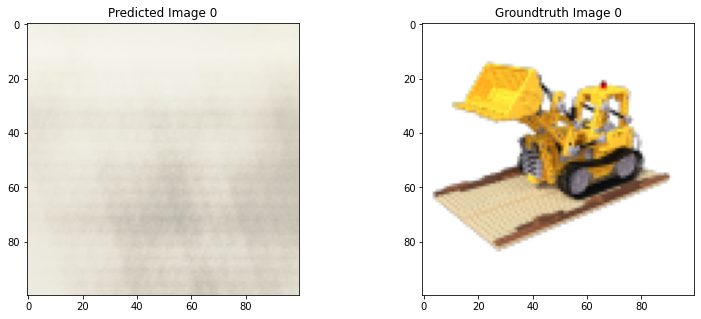

Iter 200:   7%|▋         | 219/3000 [00:48<09:38,  4.81it/s, loss=0.14, psnr=8.53, time=0.235]  

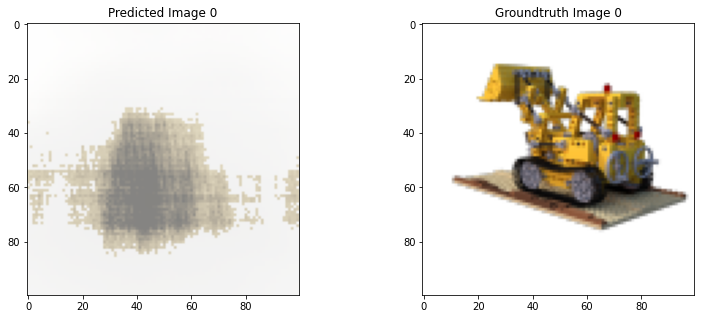

Iter 300:  11%|█         | 323/3000 [01:12<09:58,  4.47it/s, loss=0.105, psnr=9.8, time=0.226]  

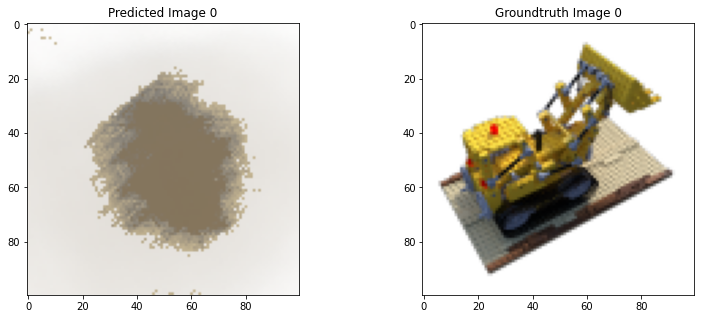

Iter 400:  14%|█▍        | 427/3000 [01:32<08:44,  4.91it/s, loss=0.0515, psnr=12.9, time=0.2]  

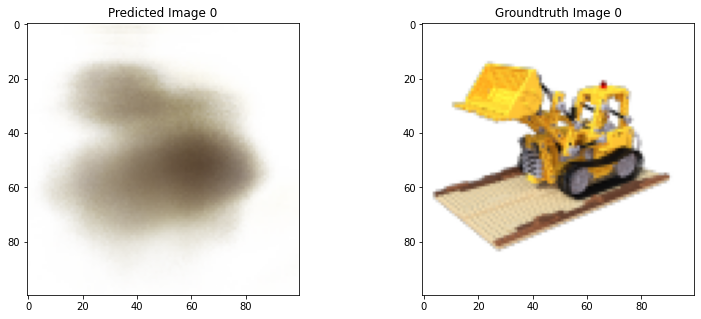

Iter 500:  18%|█▊        | 531/3000 [01:55<07:47,  5.28it/s, loss=0.0398, psnr=14, time=0.216]  

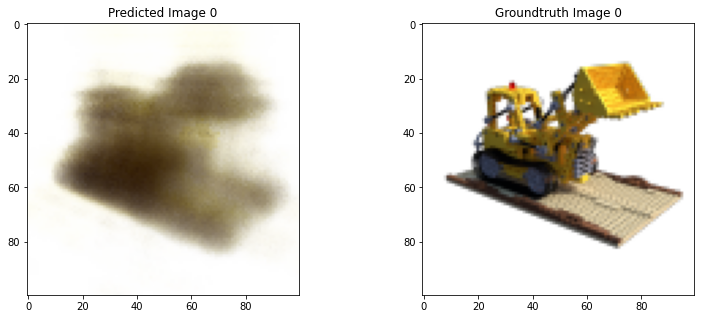

Iter 600:  21%|██        | 634/3000 [02:16<05:54,  6.68it/s, loss=0.0313, psnr=15, time=0.153]  

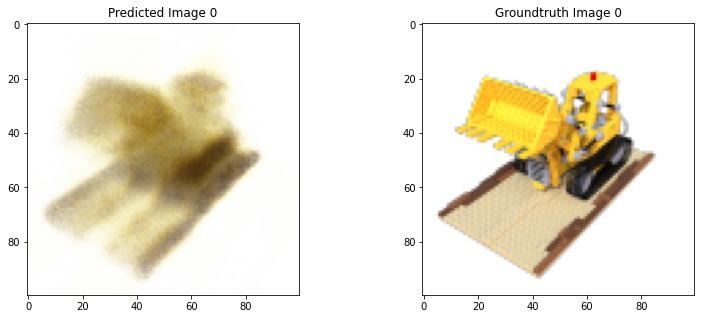

Iter 700:  25%|██▍       | 736/3000 [02:39<08:29,  4.45it/s, loss=0.0362, psnr=14.4, time=0.239]

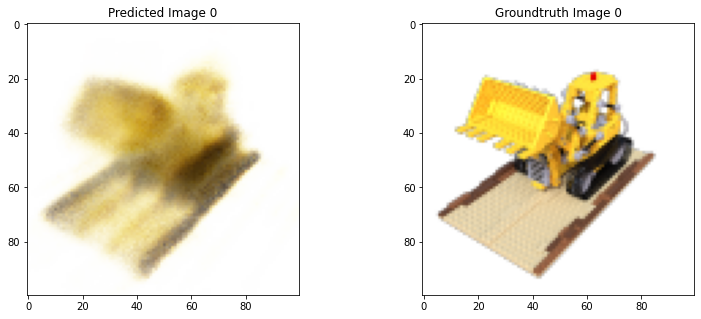

Iter 800:  28%|██▊       | 839/3000 [03:03<07:42,  4.68it/s, loss=0.0274, psnr=15.6, time=0.245]

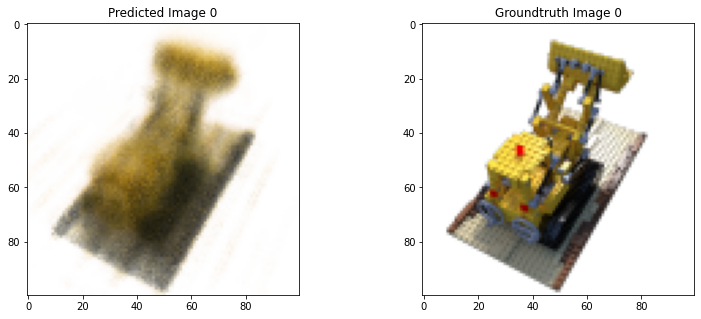

Iter 900:  31%|███▏      | 941/3000 [03:27<07:40,  4.47it/s, loss=0.024, psnr=16.2, time=0.23]  

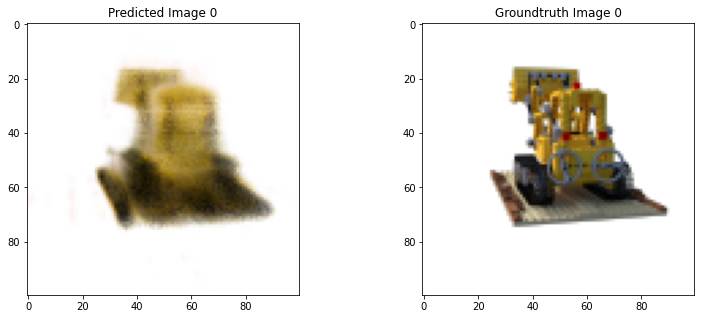

Iter 1000:  35%|███▍      | 1044/3000 [03:51<07:12,  4.53it/s, loss=0.0216, psnr=16.7, time=0.239]

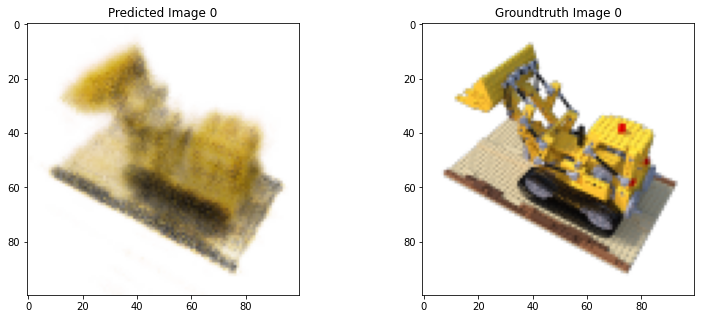

Iter 1100:  38%|███▊      | 1146/3000 [04:15<06:46,  4.56it/s, loss=0.02, psnr=17, time=0.228]    

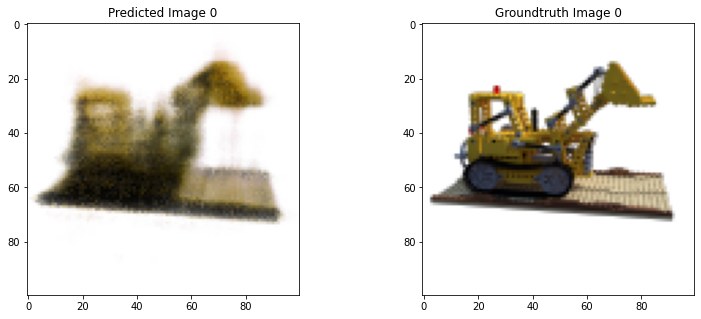

Iter 1200:  42%|████▏     | 1248/3000 [04:39<06:43,  4.35it/s, loss=0.0232, psnr=16.4, time=0.229]

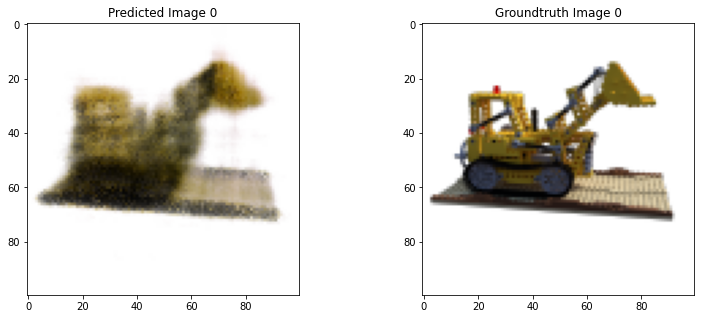

Iter 1300:  45%|████▌     | 1350/3000 [05:03<06:19,  4.35it/s, loss=0.0164, psnr=17.8, time=0.192]

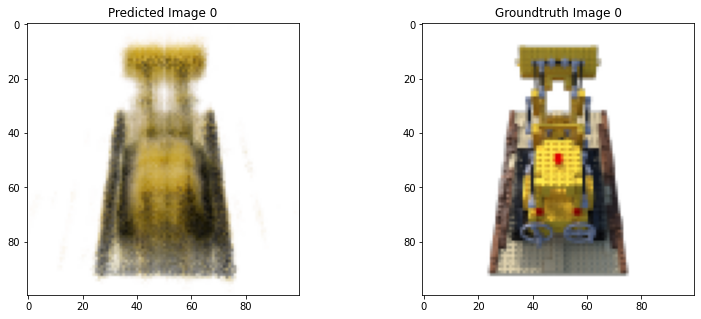

Iter 1400:  48%|████▊     | 1452/3000 [05:27<05:49,  4.44it/s, loss=0.018, psnr=17.5, time=0.239] 

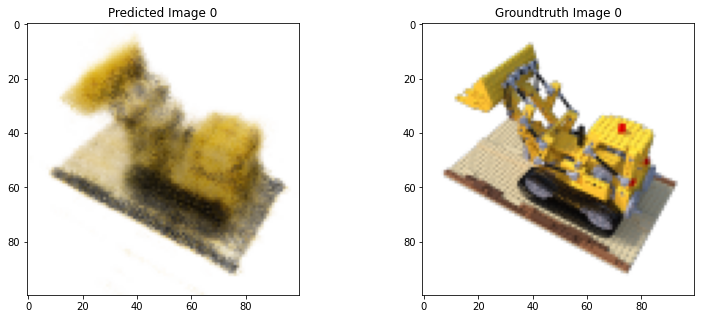

Iter 1500:  52%|█████▏    | 1554/3000 [05:51<05:28,  4.40it/s, loss=0.0162, psnr=17.9, time=0.235]

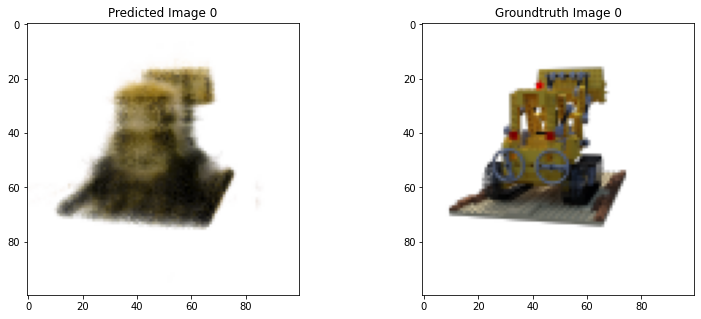

Iter 1600:  55%|█████▌    | 1656/3000 [06:15<04:23,  5.10it/s, loss=0.0176, psnr=17.6, time=0.22] 

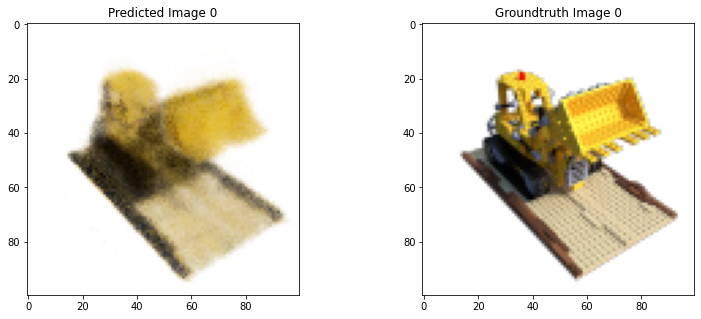

Iter 1700:  59%|█████▊    | 1757/3000 [06:39<04:46,  4.34it/s, loss=0.0189, psnr=17.2, time=0.212]

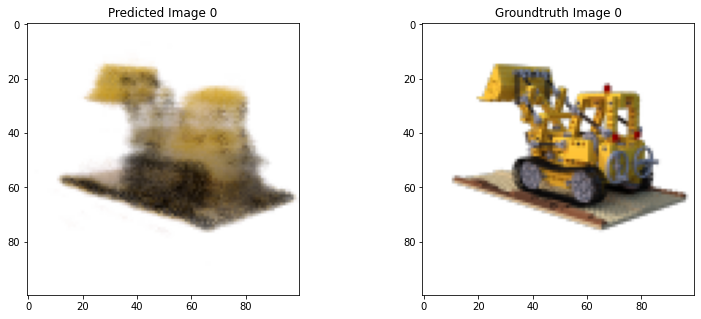

Iter 1800:  62%|██████▏   | 1859/3000 [07:03<04:24,  4.32it/s, loss=0.0157, psnr=18, time=0.192]   

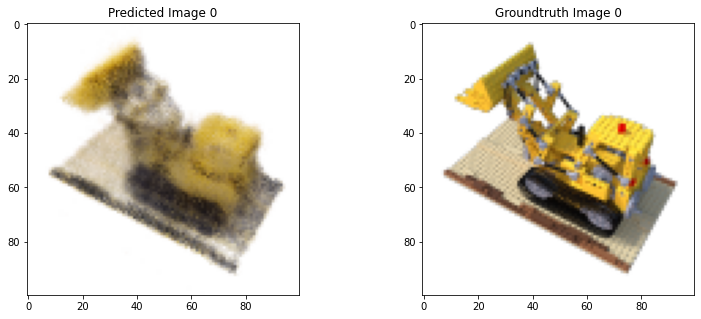

Iter 1900:  65%|██████▌   | 1961/3000 [07:27<03:51,  4.49it/s, loss=0.0175, psnr=17.6, time=0.234]

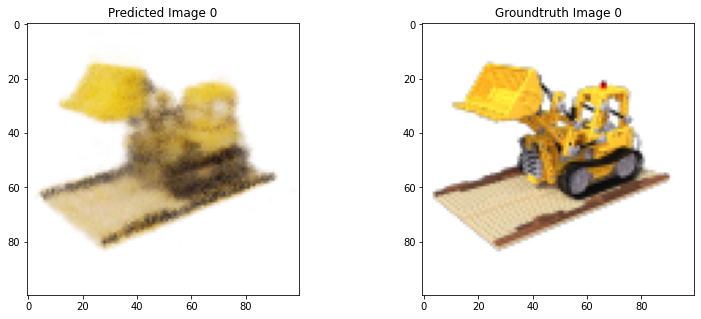

Iter 2000:  69%|██████▊   | 2062/3000 [07:51<03:24,  4.58it/s, loss=0.013, psnr=18.9, time=0.235]  

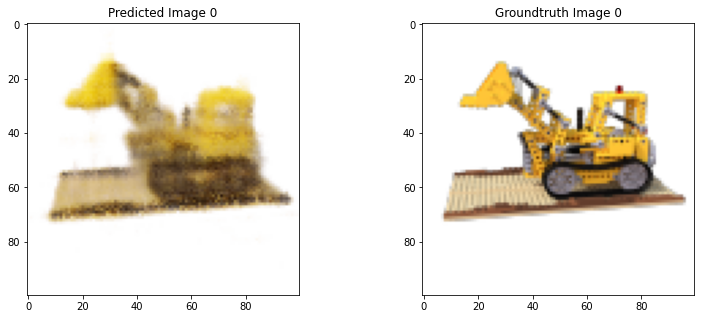

Iter 2100:  72%|███████▏  | 2164/3000 [08:12<03:00,  4.64it/s, loss=0.0141, psnr=18.5, time=0.2]  

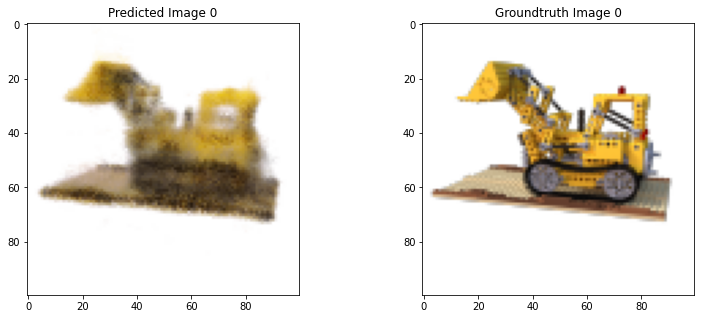

Iter 2200:  76%|███████▌  | 2265/3000 [08:34<02:26,  5.01it/s, loss=0.0152, psnr=18.2, time=0.193]

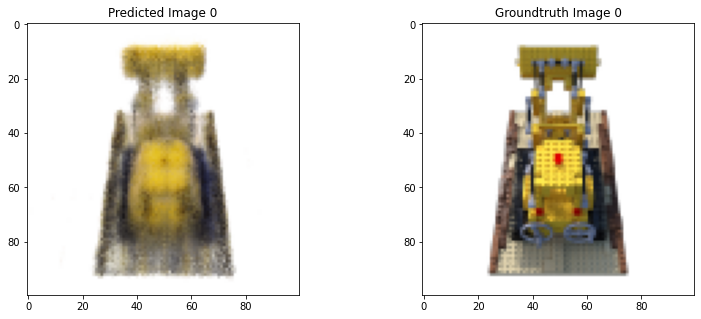

Iter 2300:  79%|███████▉  | 2367/3000 [08:57<02:03,  5.13it/s, loss=0.014, psnr=18.5, time=0.151]  

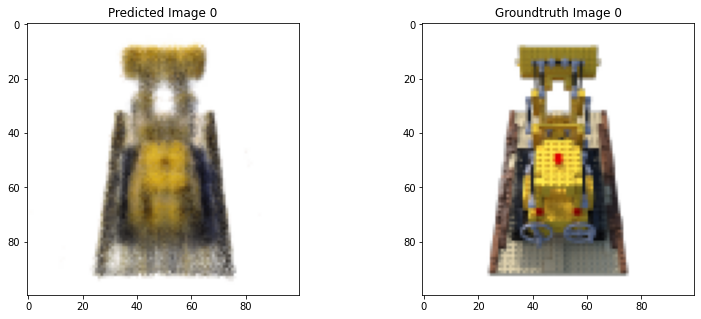

Iter 2400:  82%|████████▏ | 2468/3000 [09:19<02:02,  4.36it/s, loss=0.016, psnr=17.9, time=0.227]  

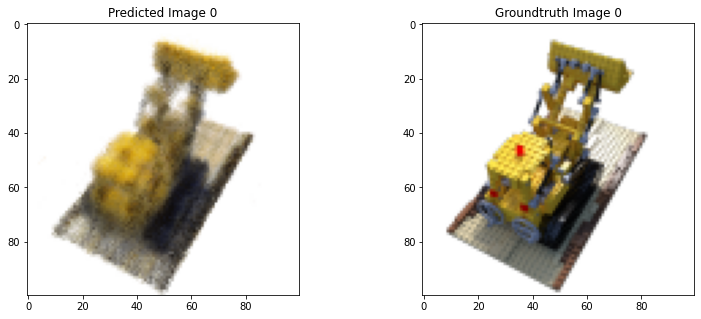

Iter 2500:  86%|████████▌ | 2570/3000 [09:43<01:38,  4.38it/s, loss=0.0148, psnr=18.3, time=0.237] 

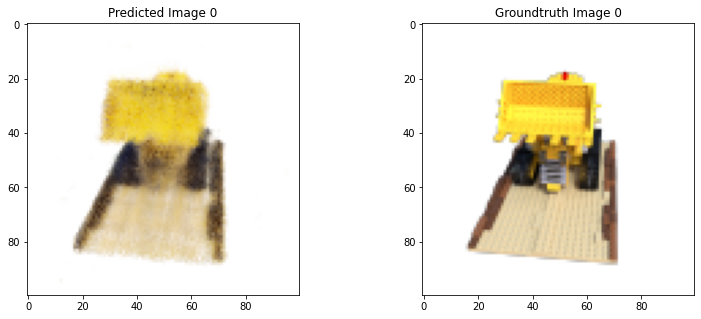

Iter 2600:  89%|████████▉ | 2671/3000 [10:07<01:16,  4.30it/s, loss=0.0125, psnr=19, time=0.194]   

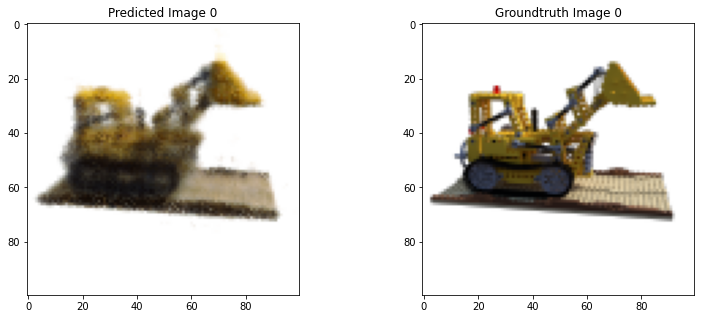

Iter 2700:  92%|█████████▏| 2772/3000 [10:31<00:52,  4.35it/s, loss=0.011, psnr=19.6, time=0.229]  

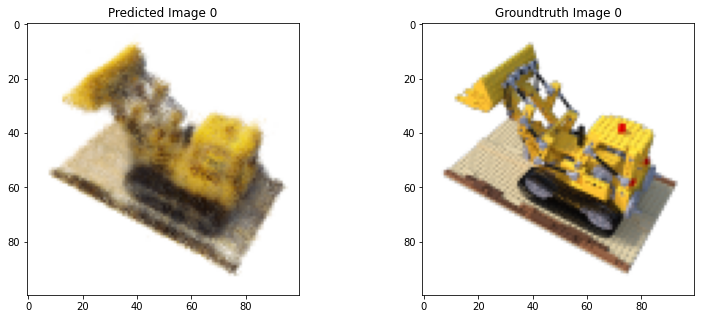

Iter 2800:  96%|█████████▌| 2874/3000 [10:55<00:28,  4.39it/s, loss=0.0103, psnr=19.9, time=0.228] 

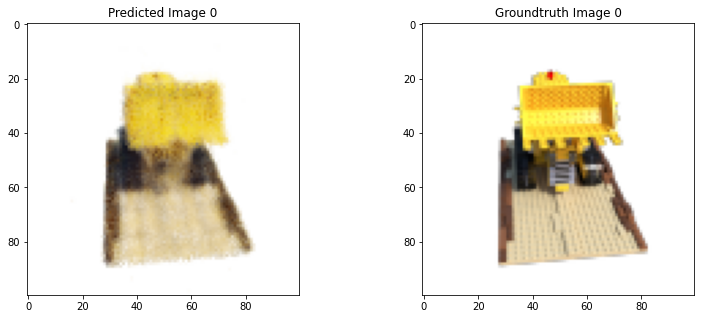

Iter 2900:  99%|█████████▉| 2975/3000 [11:19<00:05,  4.49it/s, loss=0.0103, psnr=19.9, time=0.221] 

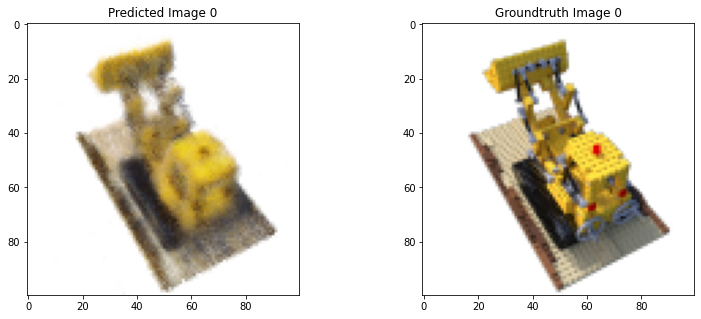

Iter 3000: : 3076it [11:43,  4.36it/s, loss=0.0136, psnr=18.7, time=0.229]                         

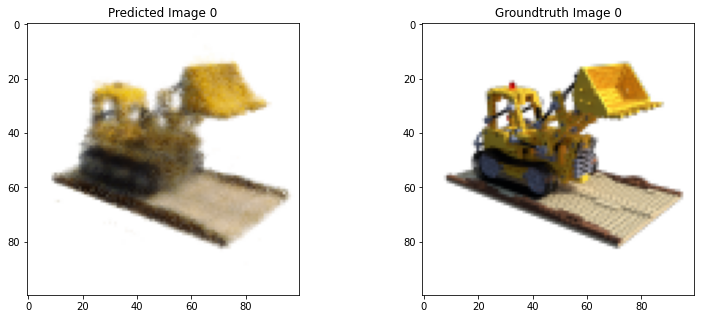

Iter 3000: 100%|██████████| 3000/3000 [11:45<00:00,  4.25it/s, loss=0.0136, psnr=18.7, time=0.229]


In [7]:
def generate_rays(h, w, f, pose):
    '''
    Given an image plane, generate rays from the camera origin to each pixel on the image plane.

    Arguments:
        h: height of the image plane.
        w: width of the image plane.
        f: focal length of the image plane.
        pose: the extrinsic parameters of the camera. (3, 4) or (4, 4)

    Returns:
        A tuple: origins of rays, directions of rays
    '''

    # Coordinates of the 2D grid
    cols = md.ops.ExpandDims()(
        md.numpy.linspace(-1.0 * w / 2, w - 1 - w / 2, w) / f,
        0).repeat(h, axis=0)  # (h, w)
    rows = md.ops.ExpandDims()(
        -1.0 * md.numpy.linspace(-1.0 * h / 2, h - 1 - h / 2, h) / f,
        1).repeat(w, axis=1)  # (h, w)

    # Ray directions for all pixels
    ray_dirs = md.numpy.stack([cols, rows, -1.0 * md.numpy.ones_like(cols)],
                              axis=-1)  # (h, w, 3)
    # Apply rotation transformation to make each ray orient according to the camera
    unsqueeze_op = md.ops.ExpandDims()
    ray_dirs = md.numpy.sum(unsqueeze_op(ray_dirs, 2) * pose[:3, :3], axis=-1)
    # Origin position
    rays_oris = pose[:3, -1].expand_as(ray_dirs)  # (h, w, 3)

    return rays_oris.astype("float32"), ray_dirs.astype(
        "float32")  # (h, w, 3), (h, w, 3)

def train_net(iter_, train_renderer, optimizer, rays, gt):
    '''
    Train a network.

    Arguments:
        config: configuration.
        iter_: current iterations.
        renderer: a volume renderer.
        optimizer: a network optimizer.
        rays: a batch of rays for training. (#rays * #samples, 6)
        gt: the groundtruth.

    Returns:
        A tuple: (MSE loss, PSNR).
    '''
    loss = train_renderer(rays, gt)

    # Update learning rate
    decay_rate = 0.1
    decay_steps = lrate_decay * 1000
    new_lrate = lrate * (decay_rate**(iter_ / decay_steps))
    optimizer.learning_rate = md.Parameter(new_lrate)

    return float(loss), float(psnr_from_mse(loss))

def test_net(img_h,
             img_w,
             focal,
             renderer,
             test_poses,
             gt=None,
             on_progress=None,
             on_complete=None):
    '''
    Test the network and generate results.

    Arguments:
        img_h: height of image plane.
        img_w: width of image plane.
        focal: focal length.
        renderer: the volume renderer.
        test_poses: poses used to test the network. (#poses, 4, 4)
        on_progress: a callback function invoked per generation of a result.
        on_complete: a callback function invoked after generating all results.

    Returns:
        A tuple: (Mean test time, MSE loss, PSNR).
    '''

    rgb_maps = []
    loss_ls = []
    psnr_ls = []
    time_ls = []

    reshape_op = md.ops.Reshape()
    stack_op = md.ops.Stack(axis=0)

    for j, test_pose in enumerate(test_poses):
        t0 = time.time()

        # Generate rays for all pixels
        ray_oris, ray_dirs = generate_rays(img_h, img_w, focal, test_pose)
        ray_oris = reshape_op(ray_oris, (-1, 3))
        ray_dirs = reshape_op(ray_dirs, (-1, 3))
        test_batch_rays = stack_op([ray_oris, ray_dirs])

        # Retrieve testing results
        rgb_map, _ = renderer(test_batch_rays)
        rgb_map = reshape_op(rgb_map, (img_h, img_w, 3))
        rgb_maps.append(rgb_map.asnumpy())

        # If given groundtruth, compute MSE and PSNR
        if gt is not None:
            loss = mse(rgb_map, gt[j])
            psnr = psnr_from_mse(loss)
            loss_ls.append(float(loss))
            psnr_ls.append(float(psnr))

        time_ls.append(time.time() - t0)

        # Handle each testing result
        if on_progress:
            if isinstance(on_progress, list):
                on_progress[0](j, rgb_maps[-1])
                if gt is not None:
                    on_progress[1](j, gt[j].asnumpy())
            else:
                on_progress(j, rgb_maps[-1])

        _, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
        ax[0].imshow(to8b(rgb_maps[-1]))
        ax[0].set_title(f"Predicted Image {j}")
        if gt is not None:
            ax[1].imshow(to8b(gt[j].asnumpy()))
            ax[1].set_title(f"Groundtruth Image {j}")
        plt.show()
        plt.close()

    # Handle all testing results
    if on_complete:
        on_complete(np.stack(rgb_maps, 0))

    if not loss_ls:
        loss_ls = [0.0]
    if not psnr_ls:
        psnr_ls = [0.0]
    if not time_ls:
        time_ls = [0.0]

    return np.mean(time_ls), np.mean(loss_ls), np.mean(psnr_ls)


def to8b(x):
    """Convert normalized color to 8-bit color"""
    return (255 * np.clip(x, 0.0, 1.0)).astype(np.uint8)


def mse(im1, im2):
    '''
    MSE between two images.
    '''

    return md.numpy.mean((im1 - im2)**2)


def psnr_from_mse(v):
    '''
    Convert MSE to PSNR.
    '''
    return -10.0 * (md.numpy.log(v) / md.numpy.log(md.Tensor([10.0])))


with tqdm(range(1, cap_n_iters + 1)) as pbar:
    pbar.n = start_iter

    for i in pbar:
        # Show progress
        pbar.set_description(f'Iter {global_steps + 1:d}')
        pbar.update()

        # Start time of the current iteration
        time0 = time.time()

        img_i = int(np.random.choice(i_train))

        target = images[img_i]
        pose = poses[img_i, :3, :4]

        if cap_n_rand is not None:
            rays_o, rays_d = generate_rays(
                cap_h, cap_w, focal, md.Tensor(
                    pose))  # (cap_h, cap_w, 3), (cap_h, cap_w, 3)
            sampled_rows, sampled_cols = sample_grid_2d(
                cap_h, cap_w, cap_n_rand)
            rays_o = rays_o[sampled_rows,
                            sampled_cols]  # (cap_n_rand, 3)
            rays_d = rays_d[sampled_rows,
                            sampled_cols]  # (cap_n_rand, 3)

            batch_rays = md.ops.Stack(axis=0)([rays_o, rays_d])
            target_s = target[sampled_rows, sampled_cols]  # (cap_n_rand, 3)

        loss, psnr = train_net(global_steps, train_renderer,
                               optimizer, batch_rays, target_s)

        pbar.set_postfix(time=time.time() - time0, loss=loss, psnr=psnr)

        # Save testing results
        if (global_steps + 1) % i_testset == 0:
            test_idx = np.random.randint(low=0, high=len(i_test))
            test_time, test_loss, test_psnr = test_net(cap_h,
                                                       cap_w,
                                                       focal,
                                                       renderer,
                                                       md.Tensor(poses[i_test[test_idx: test_idx+1].tolist()]),
                                                       images[i_test[test_idx: test_idx+1].tolist()])
        global_steps += 1

## 渲染

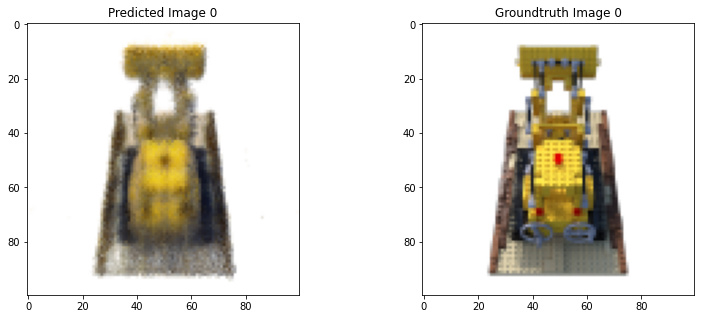

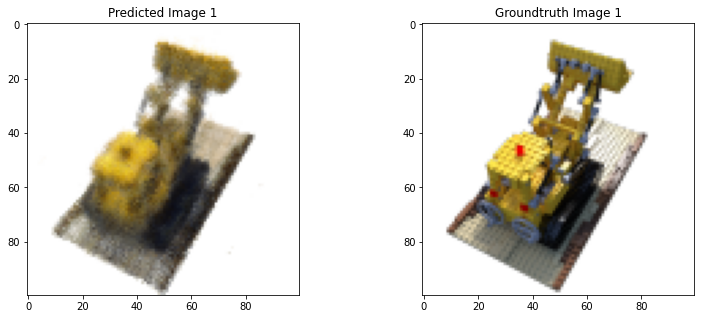

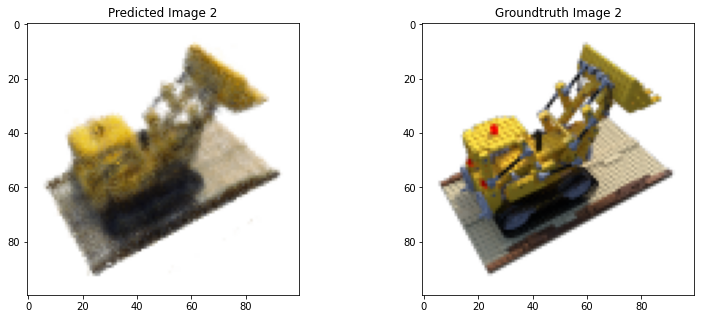

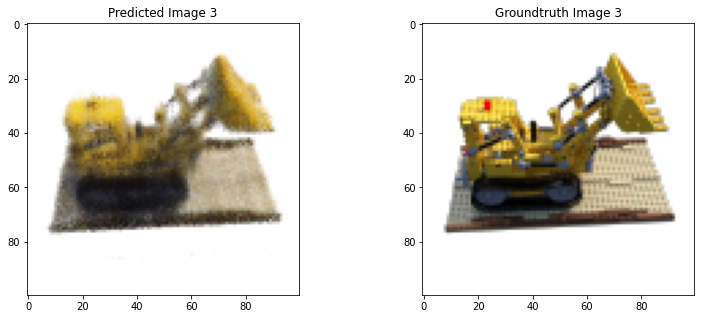

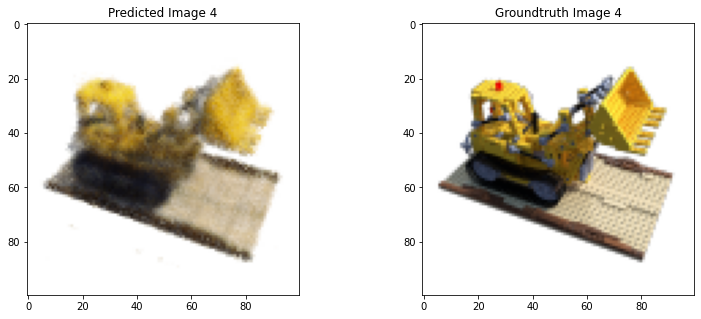

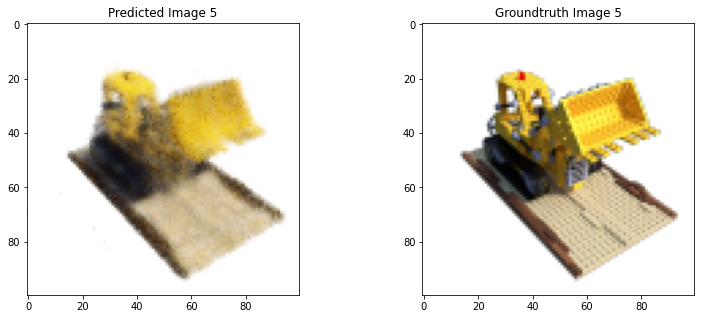

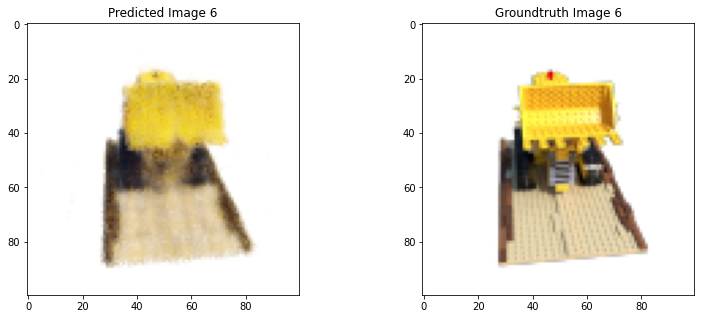

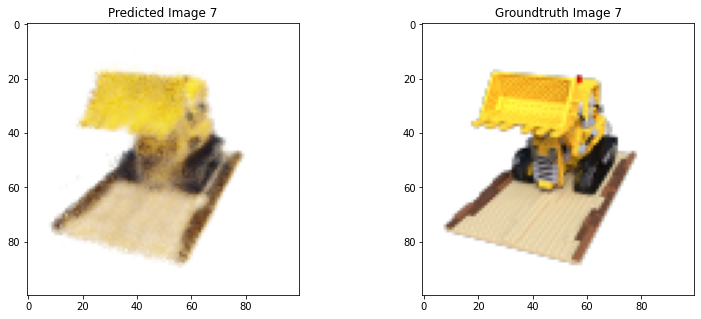

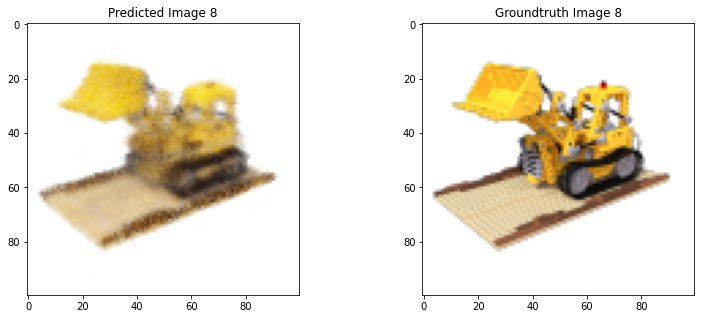

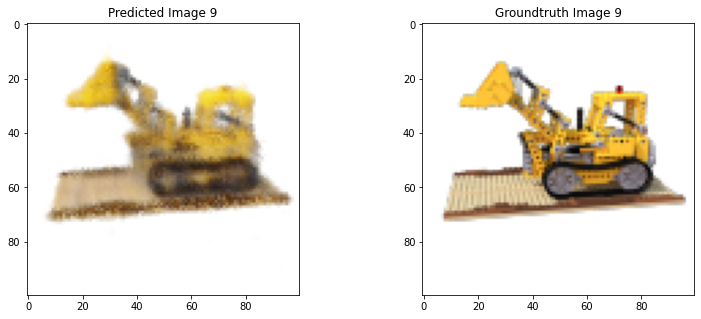

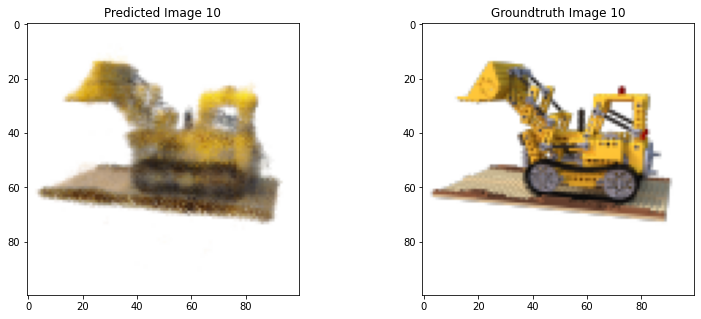

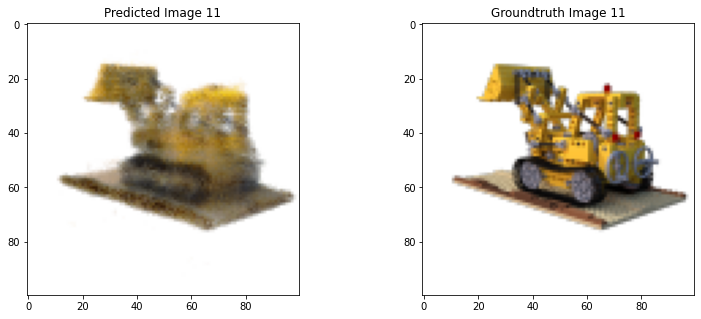

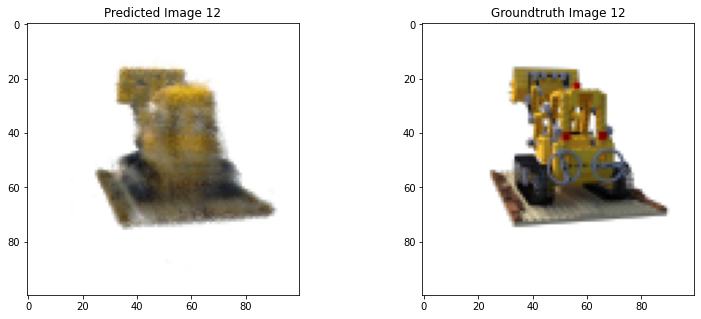

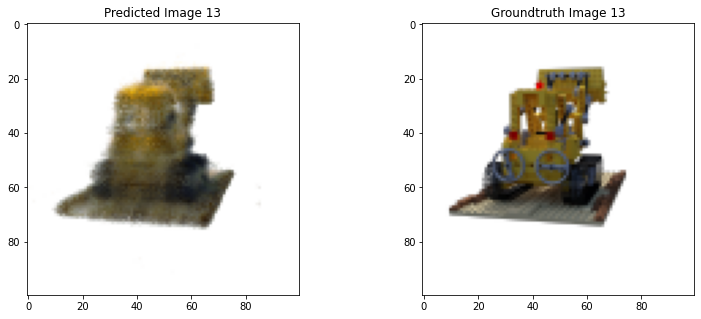

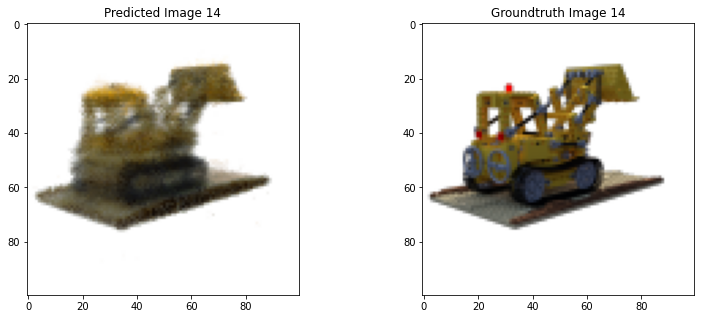

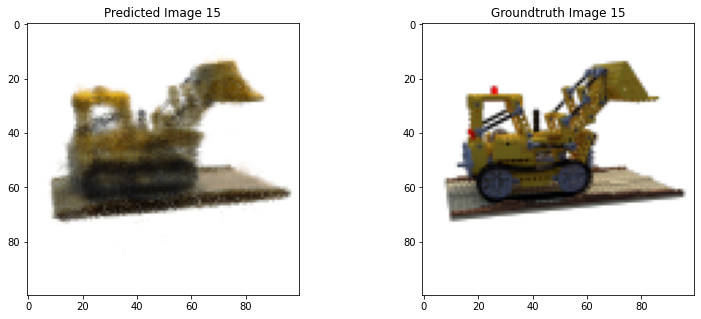

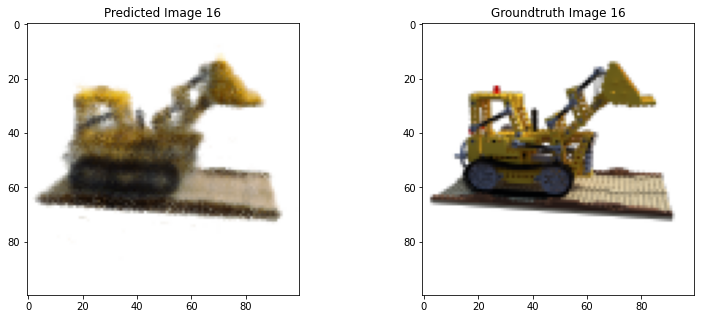

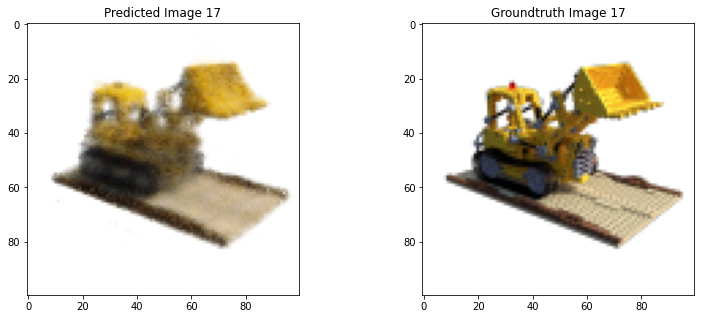

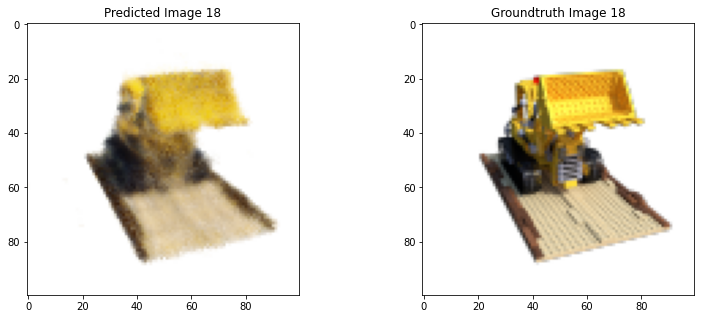

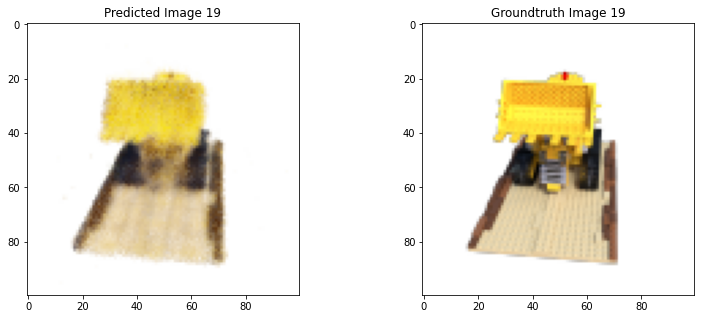

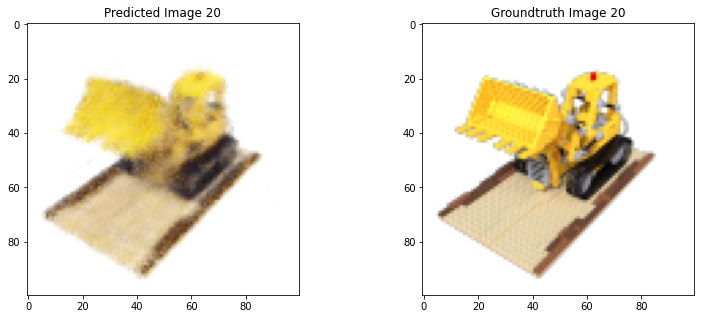

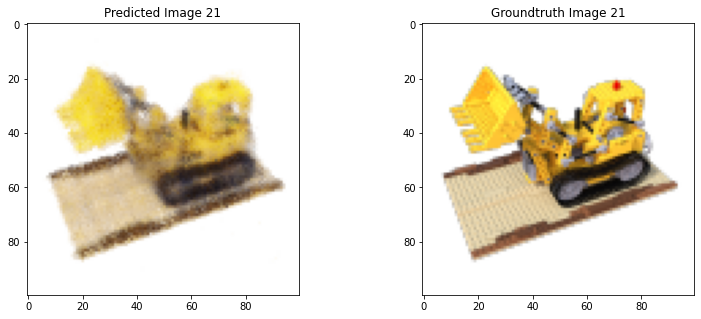

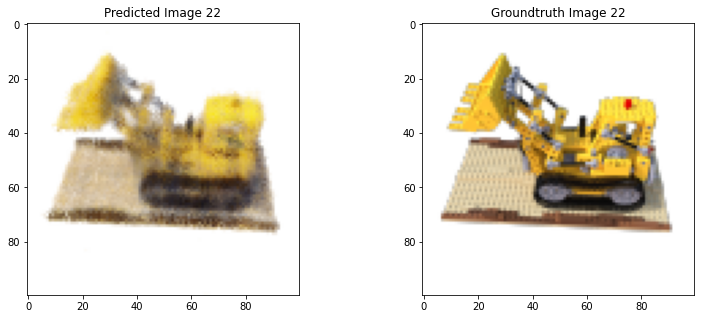

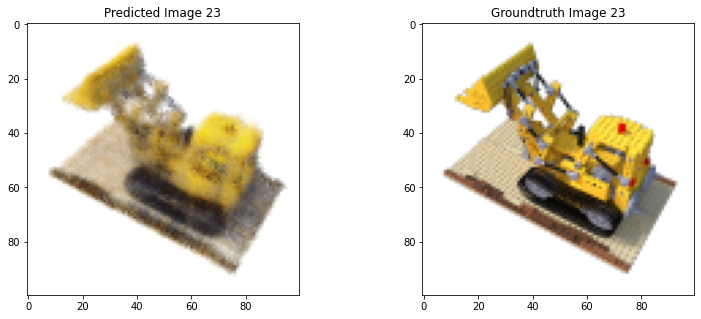

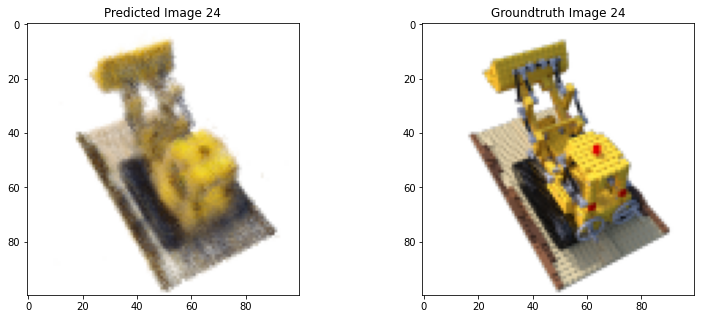

Testing results: [ Mean Time: 1.2537s, Loss: 0.0066, PSNR: 21.8860 ]


In [8]:
test_time, test_loss, test_psnr = test_net(
    cap_h,
    cap_w,
    focal,
    renderer,
    md.Tensor(poses[i_test.tolist()]),
    images[i_test.tolist()])
print(
    f"Testing results: [ Mean Time: {test_time:.4f}s, Loss: {test_loss:.4f}, PSNR: {test_psnr:.4f} ]"
)

## 总结

本案例对 NeRF 的论文中提出的模型进行了详细的解释，向读者完整地展现了该算法的流程。如需查看详细代码，可参考 `src/`。

## 引用

[1] Mildenhall, Ben et al. “NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis.” ECCV (2020).

### 参考资料

- [NeRF 仓库](https://github.com/bmild/nerf)：官方 NeRF 的存储库。

- [NeRF 视频](https://www.youtube.com/watch?v=dPWLybp4LL0)：关于 NeRF 的讲解视频。